In [1]:
!pip install interpolation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange, float64, int64
from numba.experimental import jitclass
from interpolation import interp
from math import gamma

/Users/humphreyyang/anaconda3/envs/quantecon_test/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


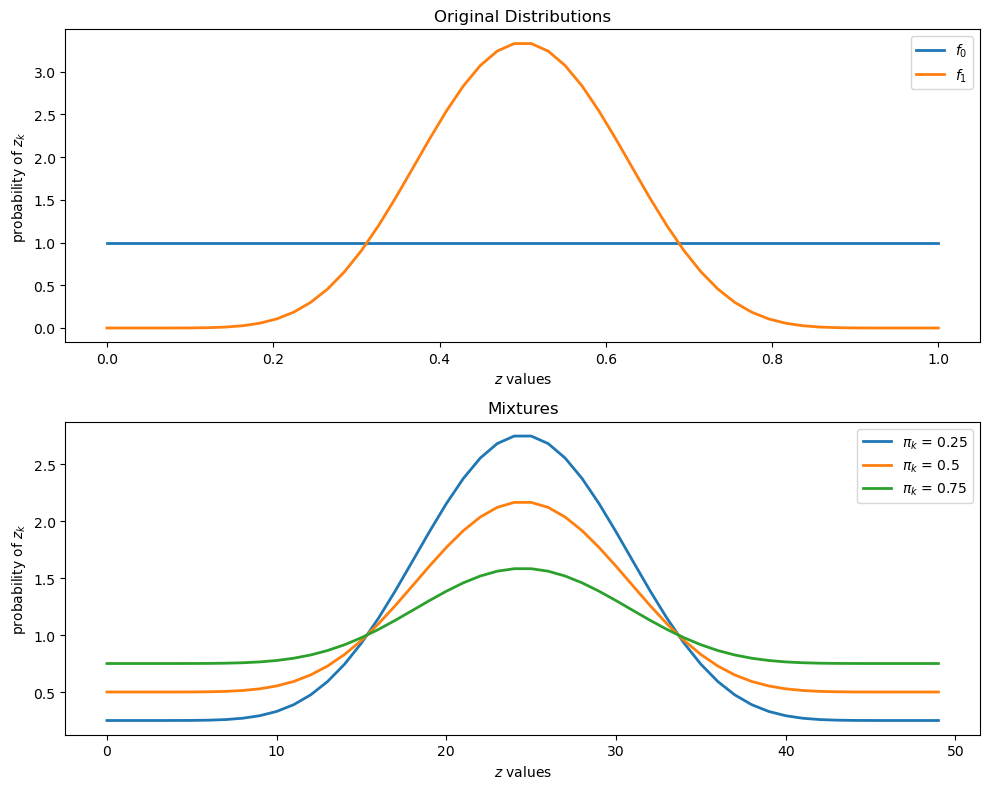

In [3]:
@jit(nopython=True)
def p(x, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x**(a-1) * (1 - x)**(b-1)

f0 = lambda x: p(x, 1, 1)
f1 = lambda x: p(x, 9, 9)
grid = np.linspace(0, 1, 50)

fig, axes = plt.subplots(2, figsize=(10, 8))

axes[0].set_title("Original Distributions")
axes[0].plot(grid, f0(grid), lw=2, label="$f_0$")
axes[0].plot(grid, f1(grid), lw=2, label="$f_1$")

axes[1].set_title("Mixtures")
for π in 0.25, 0.5, 0.75:
    y = π * f0(grid) + (1 - π) * f1(grid)
    axes[1].plot(y, lw=2, label=f"$\pi_k$ = {π}")

for ax in axes:
    ax.legend()
    ax.set(xlabel="$z$ values", ylabel="probability of $z_k$")

plt.tight_layout()
plt.show()

In [4]:
wf_data = [('a0', float64),          # Parameters of beta distributions
           ('b0', float64),
           ('a1', float64),
           ('b1', float64),
           ('c', float64),           # Cost of another draw
           ('π_grid_size', int64),
           ('L0', float64),          # Cost of selecting f0 when f1 is true
           ('L1', float64),          # Cost of selecting f1 when f0 is true
           ('π_grid', float64[:]),
           ('mc_size', int64),
           ('z0', float64[:]),
           ('z1', float64[:])]

In [5]:
@jitclass(wf_data)
class WaldFriedman:

    def __init__(self,
                 c=1.25,
                 a0=1,
                 b0=1,
                 a1=3,
                 b1=1.2,
                 L0=25,
                 L1=25,
                 π_grid_size=200,
                 mc_size=1000):

        self.a0, self.b0 = a0, b0
        self.a1, self.b1 = a1, b1
        self.c, self.π_grid_size = c, π_grid_size
        self.L0, self.L1 = L0, L1
        self.π_grid = np.linspace(0, 1, π_grid_size)
        self.mc_size = mc_size

        self.z0 = np.random.beta(a0, b0, mc_size)
        self.z1 = np.random.beta(a1, b1, mc_size)

    def f0(self, x):

        return p(x, self.a0, self.b0)

    def f1(self, x):

        return p(x, self.a1, self.b1)

    def f0_rvs(self):
        return np.random.beta(self.a0, self.b0)

    def f1_rvs(self):
        return np.random.beta(self.a1, self.b1)

    def κ(self, z, π):
        """
        Updates π using Bayes' rule and the current observation z
        """

        f0, f1 = self.f0, self.f1

        π_f0, π_f1 = π * f0(z), (1 - π) * f1(z)
        π_new = π_f0 / (π_f0 + π_f1)

        return π_new

In [6]:
@jit(nopython=True, parallel=True)
def Q(h, wf):

    c, π_grid = wf.c, wf.π_grid
    L0, L1 = wf.L0, wf.L1
    z0, z1 = wf.z0, wf.z1
    mc_size = wf.mc_size

    κ = wf.κ

    h_new = np.empty_like(π_grid)
    h_func = lambda p: interp(π_grid, h, p)

    for i in prange(len(π_grid)):
        π = π_grid[i]

        # Find the expected value of J by integrating over z
        integral_f0, integral_f1 = 0, 0
        for m in range(mc_size):
            π_0 = κ(z0[m], π)  # Draw z from f0 and update π
            integral_f0 += min((1 - π_0) * L0, π_0 * L1, h_func(π_0))

            π_1 = κ(z1[m], π)  # Draw z from f1 and update π
            integral_f1 += min((1 - π_1) * L0, π_1 * L1, h_func(π_1))

        integral = (π * integral_f0 + (1 - π) * integral_f1) / mc_size

        h_new[i] = c + integral

    return h_new

In [7]:
@jit(nopython=True)
def solve_model(wf, tol=1e-4, max_iter=1000):
    """
    Compute the continuation cost function

    * wf is an instance of WaldFriedman
    """

    # Set up loop
    h = np.zeros(len(wf.π_grid))
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        h_new = Q(h, wf)
        error = np.max(np.abs(h - h_new))
        i += 1
        h = h_new

    if error > tol:
        print("Failed to converge!")

    return h_new

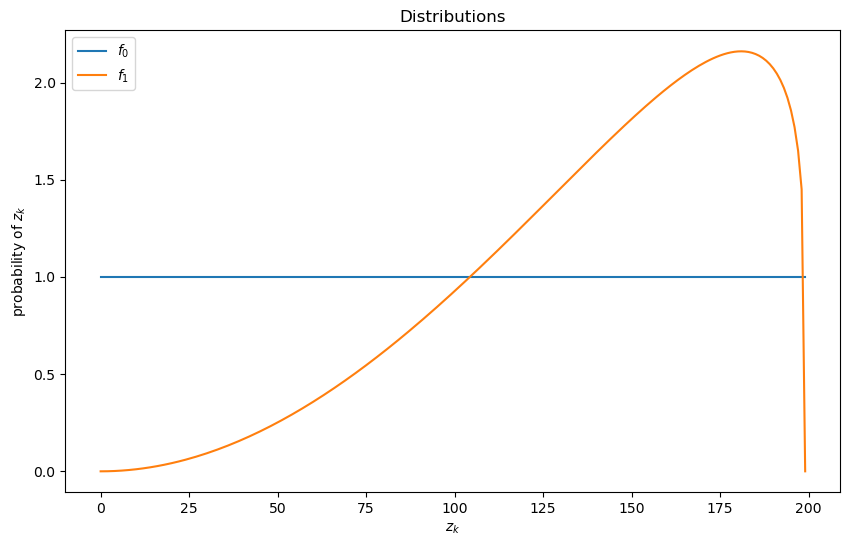

In [8]:
wf = WaldFriedman()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(wf.f0(wf.π_grid), label="$f_0$")
ax.plot(wf.f1(wf.π_grid), label="$f_1$")
ax.set(ylabel="probability of $z_k$", xlabel="$z_k$", title="Distributions")
ax.legend()

plt.show()

In [9]:
h_star = solve_model(wf)    # Solve the model

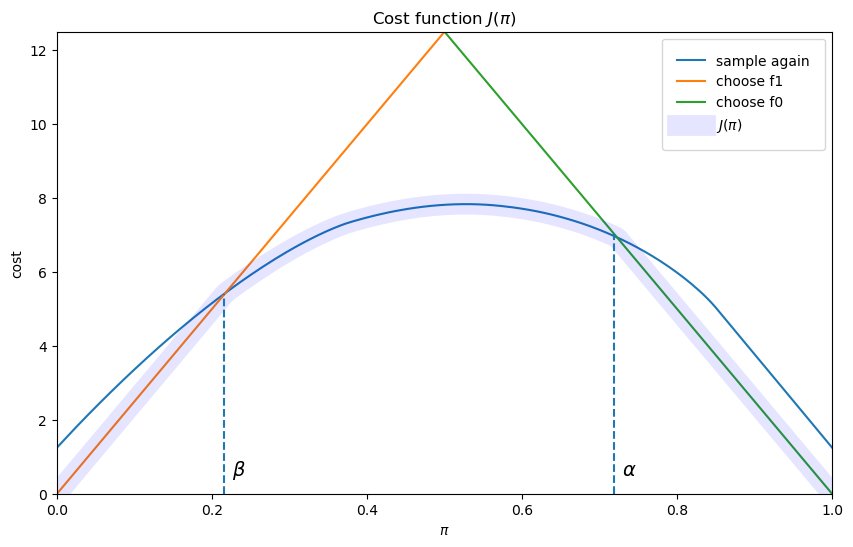

In [10]:
@jit(nopython=True)
def find_cutoff_rule(wf, h):

    """
    This function takes a continuation cost function and returns the
    corresponding cutoffs of where you transition between continuing and
    choosing a specific model
    """

    π_grid = wf.π_grid
    L0, L1 = wf.L0, wf.L1

    # Evaluate cost at all points on grid for choosing a model
    payoff_f0 = (1 - π_grid) * L0
    payoff_f1 = π_grid * L1

    # The cutoff points can be found by differencing these costs with
    # The Bellman equation (J is always less than or equal to p_c_i)
    β = π_grid[np.searchsorted(
                              payoff_f1 - np.minimum(h, payoff_f0),
                              1e-10)
               - 1]
    α = π_grid[np.searchsorted(
                              np.minimum(h, payoff_f1) - payoff_f0,
                              1e-10)
               - 1]

    return (β, α)

β, α = find_cutoff_rule(wf, h_star)
cost_L0 = (1 - wf.π_grid) * wf.L0
cost_L1 = wf.π_grid * wf.L1

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wf.π_grid, h_star, label='sample again')
ax.plot(wf.π_grid, cost_L1, label='choose f1')
ax.plot(wf.π_grid, cost_L0, label='choose f0')
ax.plot(wf.π_grid,
        np.amin(np.column_stack([h_star, cost_L0, cost_L1]),axis=1),
        lw=15, alpha=0.1, color='b', label='$J(\pi)$')

ax.annotate(r"$\beta$", xy=(β + 0.01, 0.5), fontsize=14)
ax.annotate(r"$\alpha$", xy=(α + 0.01, 0.5), fontsize=14)

plt.vlines(β, 0, β * wf.L0, linestyle="--")
plt.vlines(α, 0, (1 - α) * wf.L1, linestyle="--")

ax.set(xlim=(0, 1), ylim=(0, 0.5 * max(wf.L0, wf.L1)), ylabel="cost",
       xlabel="$\pi$", title="Cost function $J(\pi)$")

plt.legend(borderpad=1.1)
plt.show()

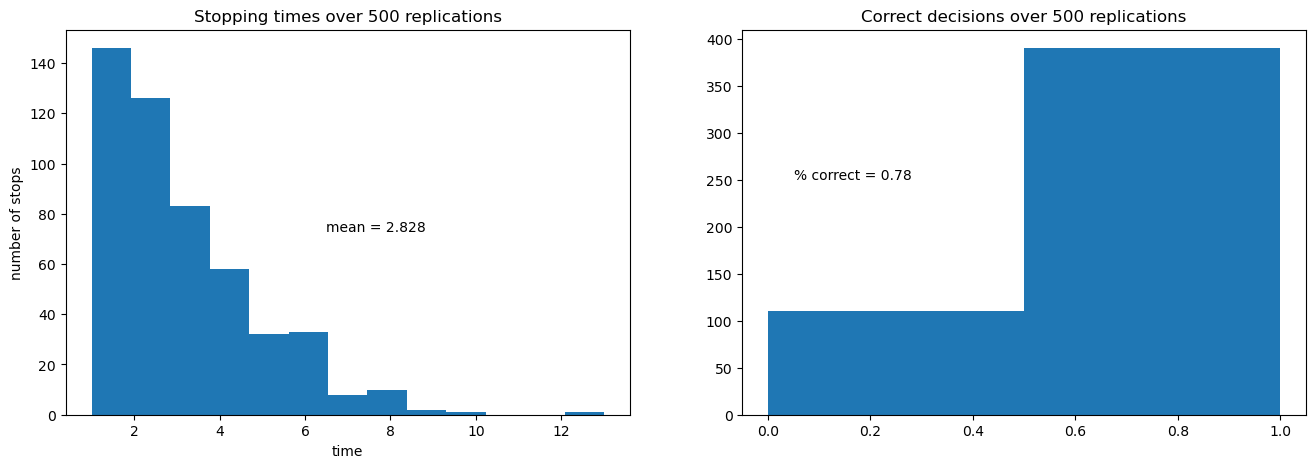

In [11]:
def simulate(wf, true_dist, h_star, π_0=0.5):

    """
    This function takes an initial condition and simulates until it
    stops (when a decision is made)
    """

    f0, f1 = wf.f0, wf.f1
    f0_rvs, f1_rvs = wf.f0_rvs, wf.f1_rvs
    π_grid = wf.π_grid
    κ = wf.κ

    if true_dist == "f0":
        f, f_rvs = wf.f0, wf.f0_rvs
    elif true_dist == "f1":
        f, f_rvs = wf.f1, wf.f1_rvs

    # Find cutoffs
    β, α = find_cutoff_rule(wf, h_star)

    # Initialize a couple of useful variables
    decision_made = False
    π = π_0
    t = 0

    while decision_made is False:
        # Maybe should specify which distribution is correct one so that
        # the draws come from the "right" distribution
        z = f_rvs()
        t = t + 1
        π = κ(z, π)
        if π < β:
            decision_made = True
            decision = 1
        elif π > α:
            decision_made = True
            decision = 0

    if true_dist == "f0":
        if decision == 0:
            correct = True
        else:
            correct = False

    elif true_dist == "f1":
        if decision == 1:
            correct = True
        else:
            correct = False

    return correct, π, t

def stopping_dist(wf, h_star, ndraws=250, true_dist="f0"):

    """
    Simulates repeatedly to get distributions of time needed to make a
    decision and how often they are correct
    """

    tdist = np.empty(ndraws, int)
    cdist = np.empty(ndraws, bool)

    for i in range(ndraws):
        correct, π, t = simulate(wf, true_dist, h_star)
        tdist[i] = t
        cdist[i] = correct

    return cdist, tdist

def simulation_plot(wf):
    h_star = solve_model(wf)
    ndraws = 500
    cdist, tdist = stopping_dist(wf, h_star, ndraws)

    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    ax[0].hist(tdist, bins=np.max(tdist))
    ax[0].set_title(f"Stopping times over {ndraws} replications")
    ax[0].set(xlabel="time", ylabel="number of stops")
    ax[0].annotate(f"mean = {np.mean(tdist)}", xy=(max(tdist) / 2,
                   max(np.histogram(tdist, bins=max(tdist))[0]) / 2))

    ax[1].hist(cdist.astype(int), bins=2)
    ax[1].set_title(f"Correct decisions over {ndraws} replications")
    ax[1].annotate(f"% correct = {np.mean(cdist)}",
                   xy=(0.05, ndraws / 2))

    plt.show()

simulation_plot(wf)

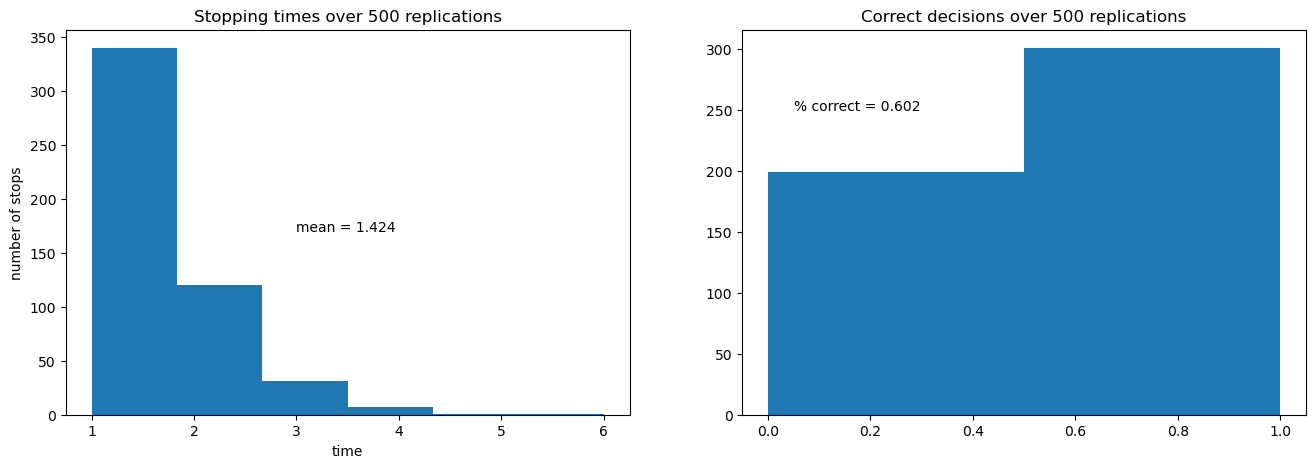

In [12]:
wf = WaldFriedman(c=2.5)
simulation_plot(wf)